# PGGAN CelebA

This notebook is for implementing `Progressive Growing Generative Adversarial Network(PGGAN)` from the paper [Progressive Growing of GANs for Improved Quality, Stability, and Variation](https://arxiv.org/abs/1710.10196) with [Tensorflow](https://www.tensorflow.org). <br>
[CelebA dataset](https://www.kaggle.com/jessicali9530/celeba-dataset), which is 128x128 size, will be used. 

Reference: [hwalsuklee's Github](https://github.com/hwalsuklee/tensorflow-generative-model-collections)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

## Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import glob
import cv2 
import datetime
import os
from skimage.transform import resize

/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/frame

## Parameters


In [3]:
algorithm = 'PGGAN_CelebA'

img_size = 128

n_latent = 512

beta1 = 0
beta2 = 0.9

learning_rate_g = 0.0002
learning_rate_d = 0.0001

show_result_step = 1000

#batch_list = [128, 128, 128, 128, 64, 64, 64, 64]
#epoch_list = [3, 3, 5, 5, 5, 5, 7, 7]
#size_list = [4, 8, 16, 32, 48, 64, 96, 128]
#channel_list = [64, 128, 256, 256, 256, 512, 512, 512]

batch_list = [128, 128, 64, 64, 32, 16]
epoch_list = [3, 3, 5, 5, 7, 7]
size_list = [4, 8, 16, 32, 64, 128]
channel_list = [64, 128, 256, 512, 512, 512]

date_time = datetime.datetime.now().strftime("%Y%m%d-%H-%M-%S")

load_model = False
train_model = True

save_path = "./saved_models/" + date_time + "_" + algorithm
load_path = "./saved_models/20190809-11-04-47_PGGAN_CelebA/model/model" 

# WGAN_GP Parateter
n_critic = 1
d_lambda = 10 

## Import CelebA Dataset

Get names of the files in the celeba dataset folder.

In [4]:
celebA_list = glob.glob('./img_align_celeba/*.jpg')

print("CelebA dataset Length: {}".format(len(celebA_list)))

CelebA dataset Length: 202599


## PGGAN Class

In [5]:
class PGGAN():
    def __init__(self, stage):
        self.stage = stage
        self.channel_list = channel_list
        
        self.x = tf.placeholder(tf.float32, shape=[None, size_list[stage], size_list[stage], 3], name='x_'+str(stage))
        self.x_normalize = (tf.cast(self.x, tf.float32) - (1.0/2)) / (1.0/2)

        self.z = tf.placeholder(tf.float32, shape=[None, n_latent], name='z_'+str(stage))
        
        self.alpha = tf.placeholder(tf.float32, shape=[1])
        self.batch_size = tf.placeholder(tf.float32)
        
        self.d_loss, self.g_loss, self.G = self.GAN(self.x_normalize, self.z) 

        # optimization
        self.trainable_vars = tf.trainable_variables()

        self.trainable_vars_d = [var for var in self.trainable_vars if var.name.startswith('Discriminator' + str(self.stage))]
        self.trainable_vars_g = [var for var in self.trainable_vars if var.name.startswith('Generator' + str(self.stage))]
        
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            optimizer_d = tf.train.AdamOptimizer(learning_rate_d, beta1, beta2)
            gvs_d = optimizer_d.compute_gradients(self.d_loss, var_list=self.trainable_vars_d)
            capped_gvs_d = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs_d]
            self.train_step_d = optimizer_d.apply_gradients(capped_gvs_d)
            
            optimizer_g = tf.train.AdamOptimizer(learning_rate_g, beta1, beta2)
            gvs_g = optimizer_g.compute_gradients(self.g_loss, var_list=self.trainable_vars_g)
            capped_gvs_g = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs_g]
            self.train_step_g = optimizer_g.apply_gradients(capped_gvs_g)

    def GAN(self, x, z):
        # Generator
        G, mini_std = self.Generator(z)

        # Discriminator
        D_logit_real, D_out_real = self.Discriminator(x, mini_std)
        D_logit_fake, D_out_fake = self.Discriminator(G, mini_std, reuse=True)
    
        # get loss (LSGAN)
        ########################################### LSGAN ###########################################
        d_loss = tf.reduce_mean(tf.square(D_logit_real-1)) + tf.reduce_mean(tf.square(D_logit_fake))
        g_loss = tf.reduce_mean(tf.square(D_logit_fake-1))
        #############################################################################################
        
        return d_loss, g_loss , G
    
    # Pixel Normalization
    def pixel_norm(self, x, epsilon=1e-8):
        return x * tf.rsqrt(tf.reduce_mean(tf.square(x), axis=-1, keepdims=True) + epsilon)
    
    # Minibatch Standard Deviation
    def minibatch_std(self, x):
        # Compute Standard Deviation over minibatch
        _, batch_std = tf.nn.moments(x, axes=[0], keep_dims=True)
        
        # Average all features
        feature_avg = tf.reduce_mean(batch_std, axis=-1, keepdims=True)
        
        # Replicate the value to concatenate it over the minibatch
        out = tf.tile(feature_avg, multiples=[self.batch_size, 1, 1, 1])
        
        return out

    def conv_block_g(self, x, num_channel, network_name):        
        h1 = tf.layers.conv2d(x, filters=num_channel, kernel_size=3, strides=1, padding='SAME', name=network_name+'_1')
        h1 = tf.nn.leaky_relu(self.pixel_norm(h1))  
            
        h2 = tf.layers.conv2d(h1, filters=num_channel, kernel_size=3, strides=1, padding='SAME', name=network_name+'_2')
        h2 = tf.nn.leaky_relu(self.pixel_norm(h2))  
        
        return h2

    
    def conv_block_d(self, x, num_channel, network_name):
        h1 = tf.layers.conv2d(x, filters=num_channel, kernel_size=3, strides=1, padding='SAME', name=network_name+'_1')
        h1 = tf.nn.leaky_relu(h1)
        
        h2 = tf.layers.conv2d(h1, filters=num_channel, kernel_size=3, strides=1, padding='SAME', name=network_name+'_2')
        h2 = tf.nn.leaky_relu(h2)

        return h2

    def Generator(self, x, reuse=False):
        with tf.variable_scope('Generator' + str(self.stage), reuse=reuse):       
            # Project and Reshape 
            z_size = int(size_list[0]/4)
            
            x_project = tf.layers.dense(x, z_size*z_size*n_latent)
            x_reshape = tf.reshape(x_project, (-1, z_size, z_size, n_latent))
            
            h1 = tf.layers.conv2d_transpose(x_reshape,filters=channel_list[-1], kernel_size=4, strides=4, padding='SAME')
            h1 = tf.nn.leaky_relu(self.pixel_norm(h1))
            
            h2 = tf.layers.conv2d(h1,filters=channel_list[-1], kernel_size=3, strides=1, padding='SAME')
            h2 = tf.nn.leaky_relu(self.pixel_norm(h2))  

            mini_std = self.minibatch_std(h2)
        
            in_block = h2
            out_block = h2
            upsample = h2

            for i in range(self.stage):
                upsample = tf.image.resize_nearest_neighbor(in_block, (size_list[i+1], size_list[i+1]))
                out_block = self.conv_block_g(upsample, channel_list[-2-i], 'block'+str(i))
                in_block = out_block

            # Output layer           
            RGB1 = tf.layers.conv2d(upsample, filters=3, kernel_size=1, strides=1, padding='SAME', name='RGB1_'+str(self.stage)) 
            RGB2 = tf.layers.conv2d(out_block, filters=3, kernel_size=1, strides=1, padding='SAME', name='RGB2_'+str(self.stage)) 
            
            logits = (1-self.alpha)*RGB1 + self.alpha*RGB2
            
            output = tf.tanh(logits)
        
        return output, mini_std      


    def Discriminator(self, x, mini_std, reuse=False):
        with tf.variable_scope('Discriminator' + str(self.stage), reuse=reuse):
            
            h1 = tf.layers.conv2d(x, filters=channel_list[-self.stage-1], kernel_size=1, strides=1, activation=tf.nn.leaky_relu, 
                      padding='SAME', name='h1_'+str(self.stage))
                
            in_block = h1
            out_block = h1
            
            for i in range(self.stage):
                out_block = self.conv_block_d(in_block, channel_list[-self.stage+i], 'block'+str(self.stage-1-i))
                
                if i == 0:
                    out_downsample = tf.layers.average_pooling2d(out_block, 2, 2)
                    in_downsample = tf.layers.average_pooling2d(in_block, 2, 2)
                    in_feature = tf.layers.conv2d(in_downsample, filters=out_downsample.get_shape()[3], 
                                                  kernel_size=1, strides=1, padding='SAME', name='feature_'+str(self.stage))
                    out_block = (1-self.alpha)*in_feature + self.alpha*out_downsample
                else:
                    out_block = tf.layers.average_pooling2d(out_block, 2, 2)
                    
                in_block = out_block           
            
            # Output layer
            out_add_std = tf.concat([out_block, mini_std], axis=-1)
            
            h2 = tf.layers.conv2d(out_add_std, filters=channel_list[-1], kernel_size=3, strides=1, 
                                  activation=tf.nn.leaky_relu, padding='SAME', name='h2')
            h3 = tf.layers.conv2d(h2, filters=channel_list[-1], kernel_size=4, strides=4, 
                                  activation=tf.nn.leaky_relu, padding='SAME', name='h3')
            
            # Output layer
            flatten = tf.reshape(h3, (-1, h3.get_shape()[3]))

            logit  = tf.layers.dense(flatten, 1, name='logit_'+str(self.stage))
            output = tf.sigmoid(logit)  

        return logit, output

In [6]:
model_list = []

for i in range(len(size_list)):
    model_list.append(PGGAN(i))

## Initialization

In [7]:
# Initialize variables
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

## Load Model

In [8]:
os.mkdir(save_path)

Saver = tf.train.Saver()

if load_model == True:
    Saver.restore(sess, load_path)

## Train

Epoch: 1 / Batch: 0.632% / G Loss: 0.67294 / D Loss: 0.23762


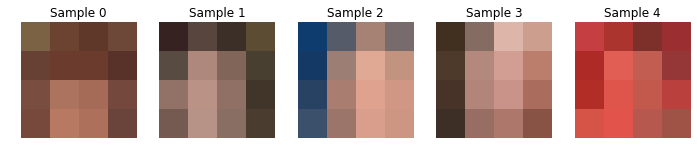

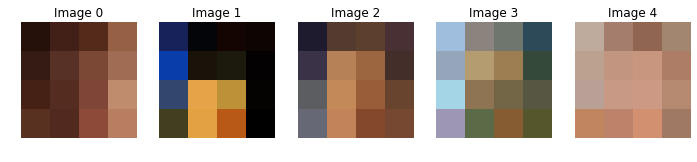

Epoch: 2 / Batch: 0.263% / G Loss: 0.32667 / D Loss: 0.49562


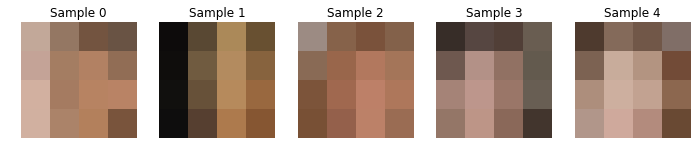

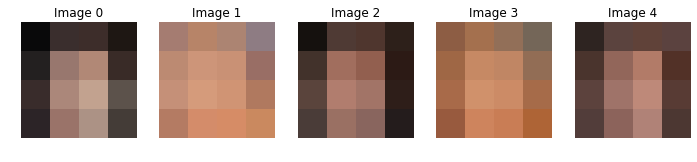

Epoch: 2 / Batch: 0.895% / G Loss: 0.38299 / D Loss: 0.42261


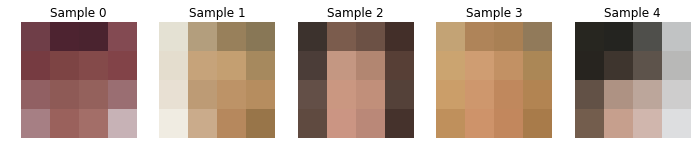

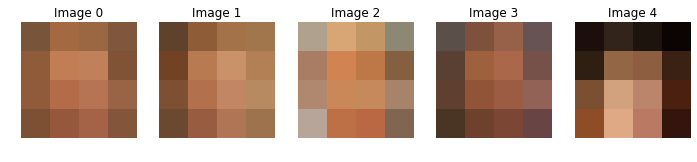

Epoch: 3 / Batch: 0.527% / G Loss: 0.39315 / D Loss: 0.44075


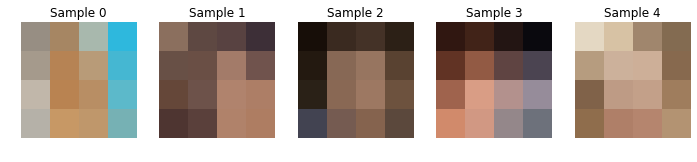

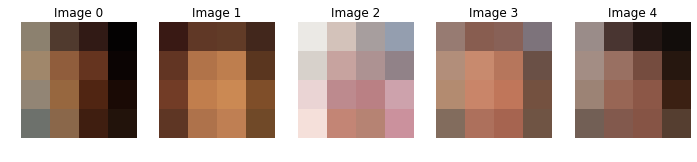

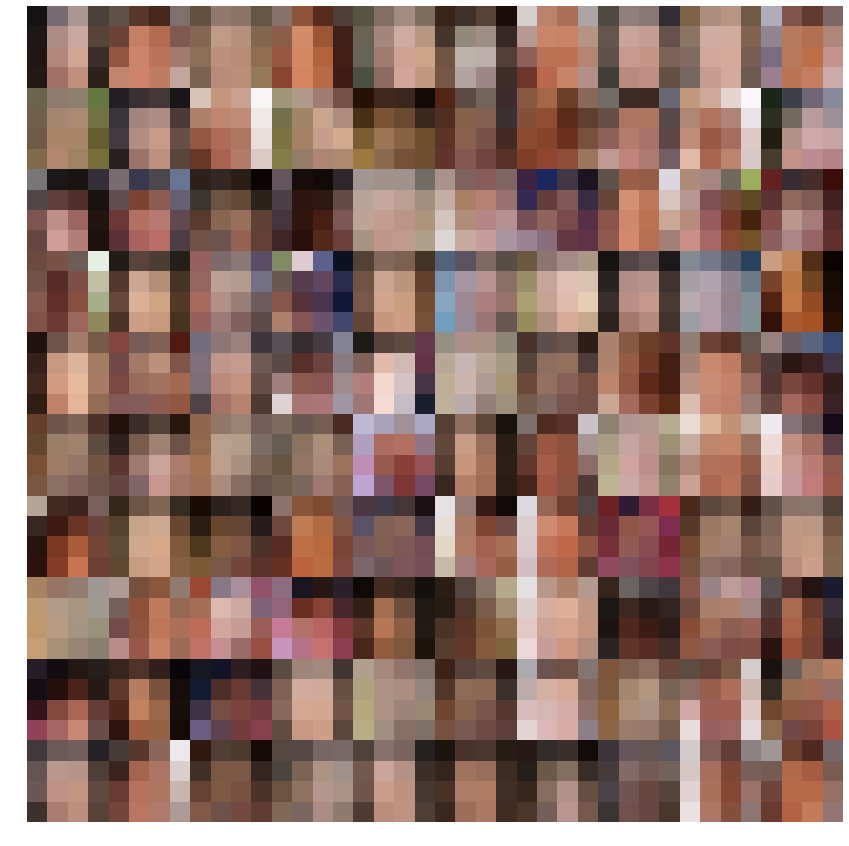


------------------ Level 0 is DONE!! ------------------

------------------- Var Assign is Finished! -------------------
Epoch: 1 / Batch: 0.632% / G Loss: 0.43539 / D Loss: 0.42228


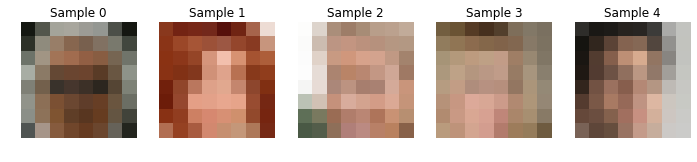

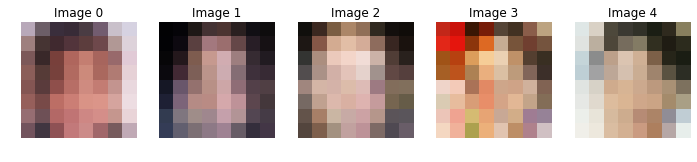

Epoch: 2 / Batch: 0.263% / G Loss: 0.48213 / D Loss: 0.38629


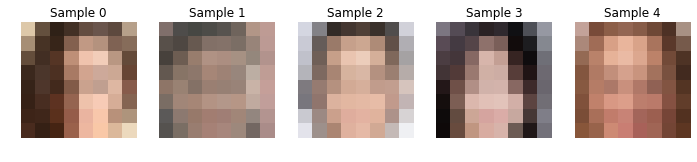

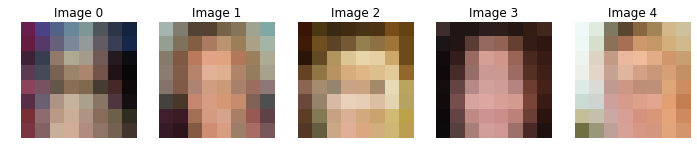

Epoch: 2 / Batch: 0.895% / G Loss: 0.36461 / D Loss: 0.46934


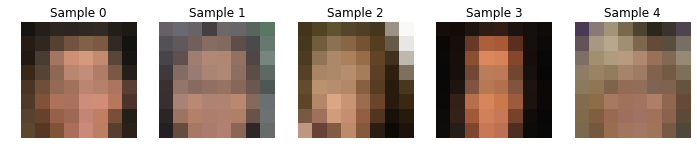

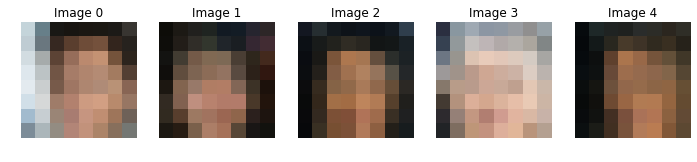

Epoch: 3 / Batch: 0.527% / G Loss: 0.31714 / D Loss: 0.48719


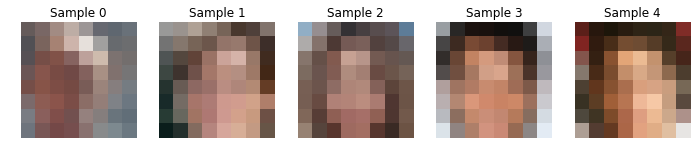

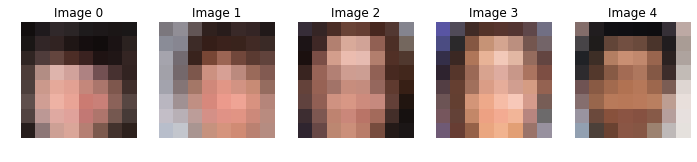

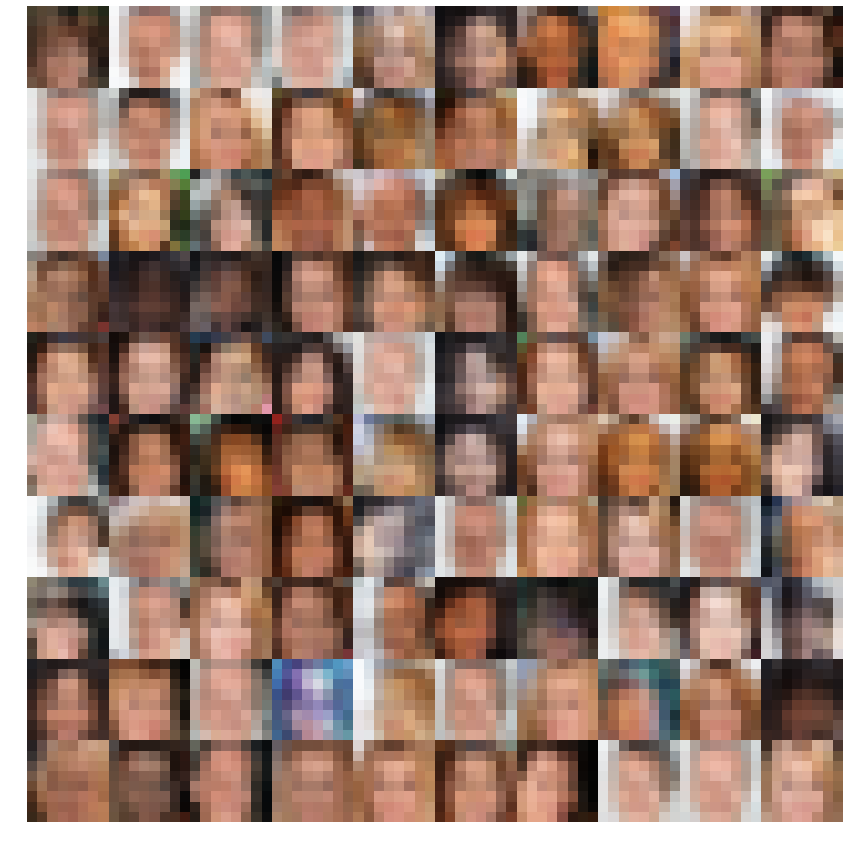


------------------ Level 1 is DONE!! ------------------

------------------- Var Assign is Finished! -------------------
Epoch: 1 / Batch: 0.316% / G Loss: 0.29763 / D Loss: 0.49808


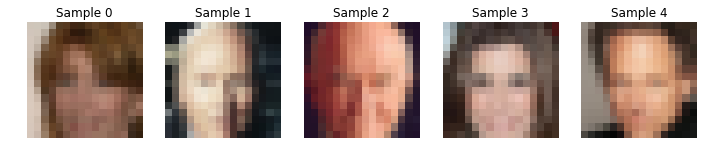

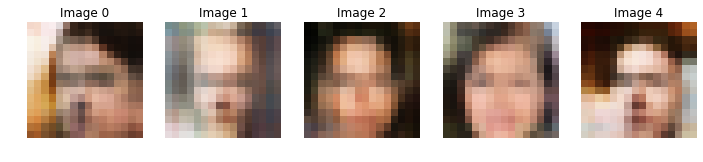

Epoch: 1 / Batch: 0.632% / G Loss: 0.31486 / D Loss: 0.47882


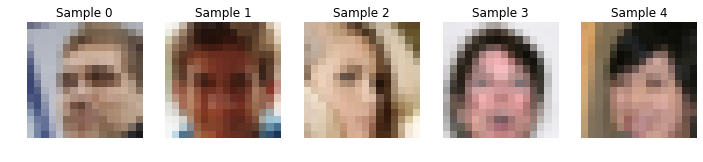

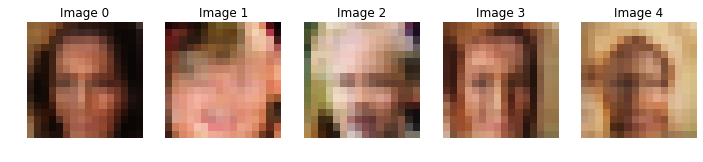

Epoch: 1 / Batch: 0.948% / G Loss: 0.30774 / D Loss: 0.55458


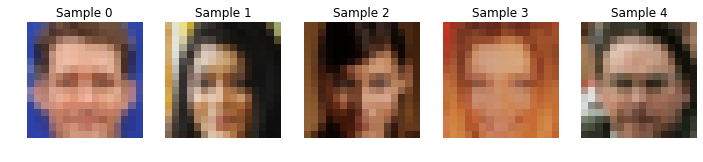

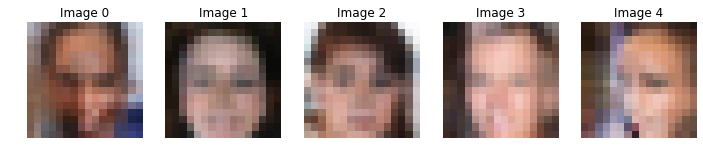

Epoch: 2 / Batch: 0.263% / G Loss: 0.37109 / D Loss: 0.50633


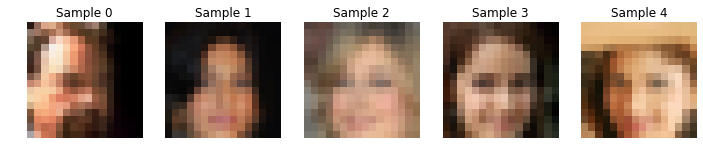

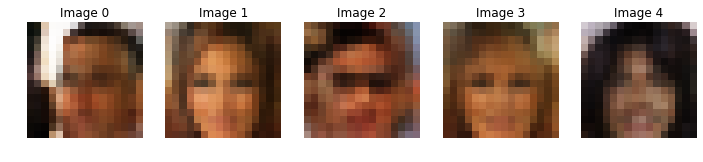

Epoch: 2 / Batch: 0.579% / G Loss: 0.37123 / D Loss: 0.50438


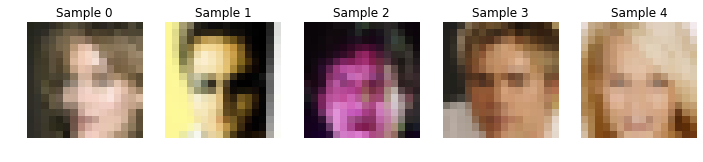

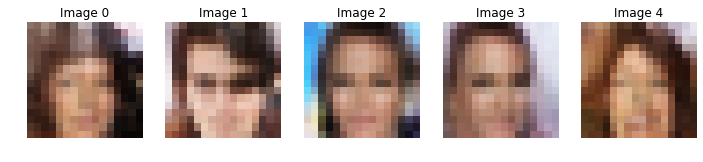

Epoch: 2 / Batch: 0.895% / G Loss: 0.37324 / D Loss: 0.47413


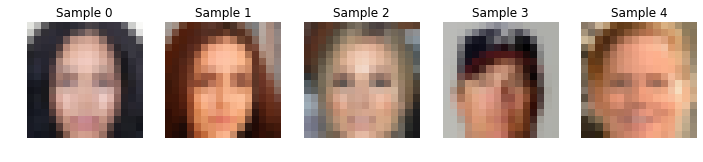

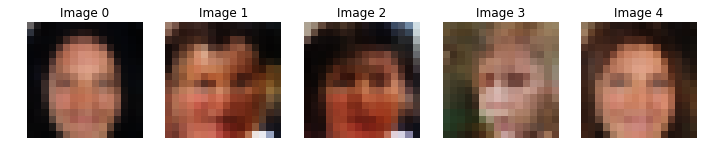

Epoch: 3 / Batch: 0.211% / G Loss: 0.42626 / D Loss: 0.46827


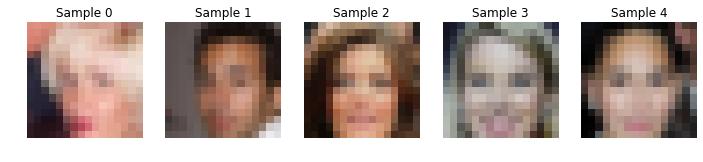

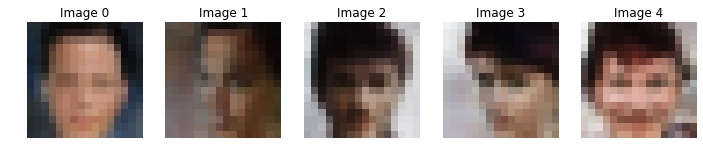

Epoch: 3 / Batch: 0.527% / G Loss: 0.40304 / D Loss: 0.45326


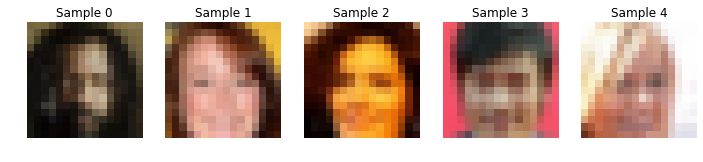

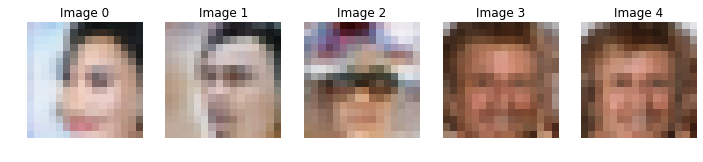

Epoch: 3 / Batch: 0.843% / G Loss: 0.31509 / D Loss: 0.49337


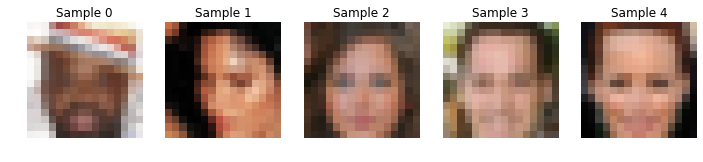

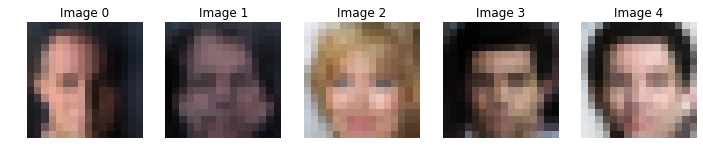

Epoch: 4 / Batch: 0.159% / G Loss: 0.43116 / D Loss: 0.48496


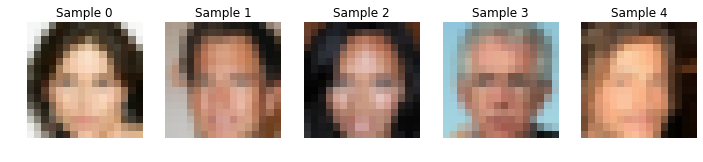

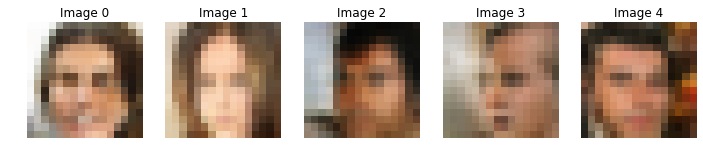

Epoch: 4 / Batch: 0.474% / G Loss: 0.57379 / D Loss: 0.52834


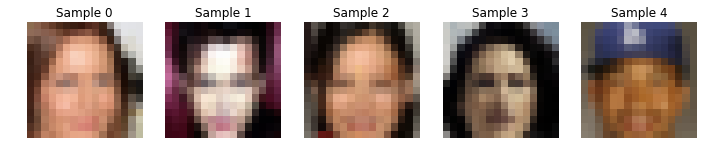

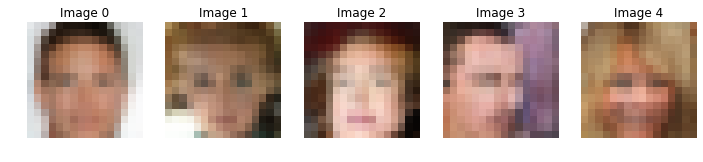

Epoch: 4 / Batch: 0.790% / G Loss: 0.35380 / D Loss: 0.47035


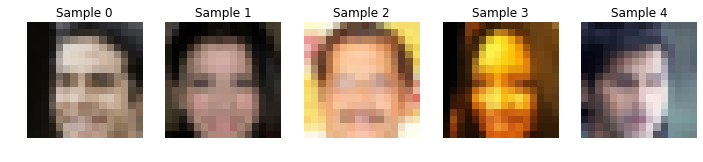

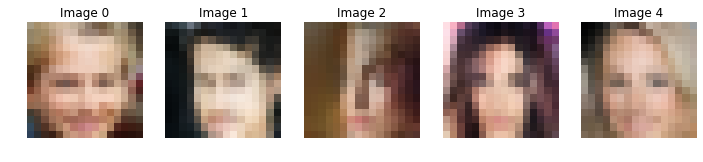

Epoch: 5 / Batch: 0.106% / G Loss: 0.39316 / D Loss: 0.50803


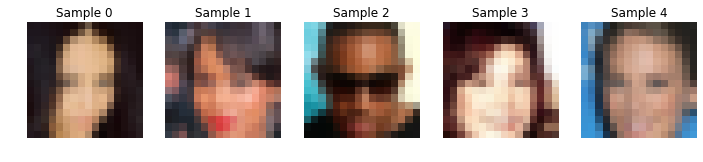

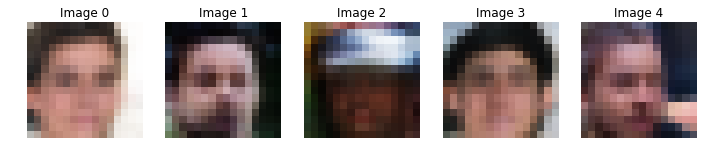

Epoch: 5 / Batch: 0.422% / G Loss: 0.56642 / D Loss: 0.51011


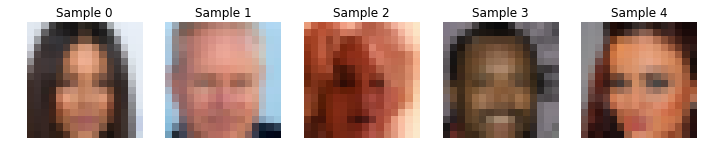

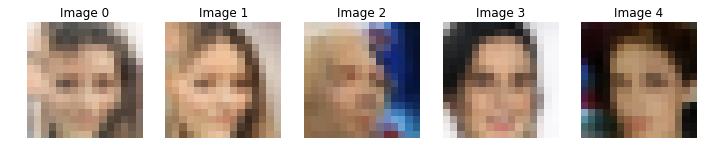

Epoch: 5 / Batch: 0.738% / G Loss: 0.47853 / D Loss: 0.45499


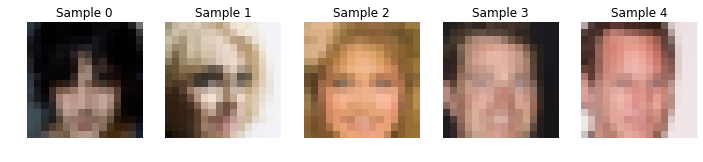

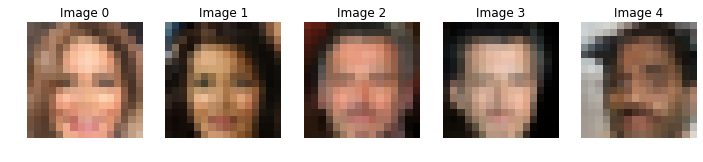

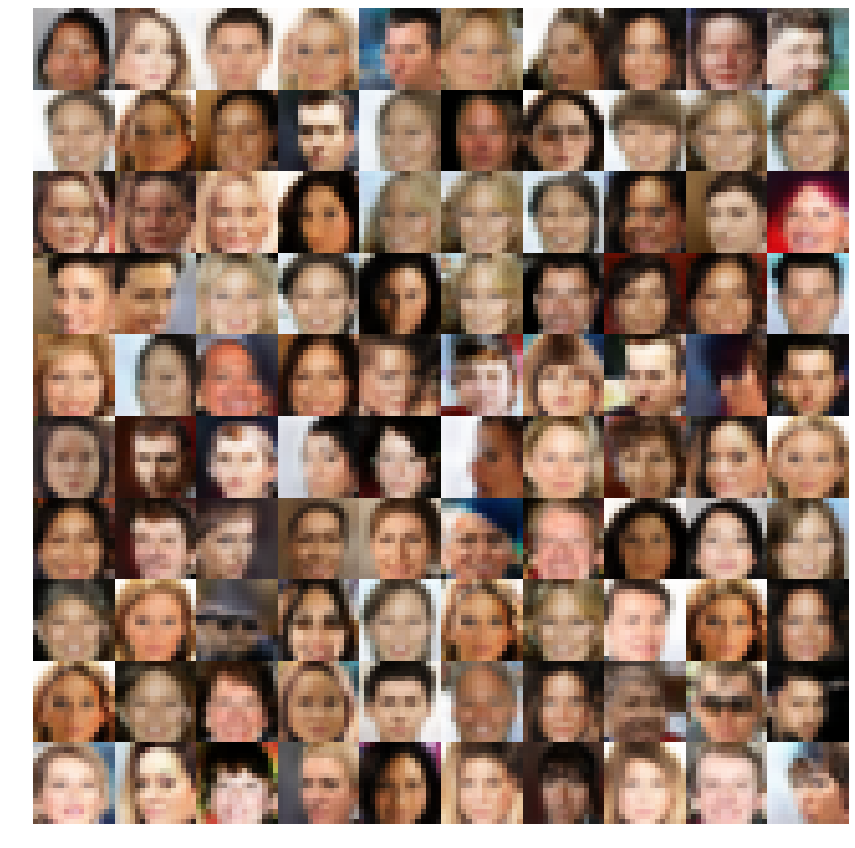


------------------ Level 2 is DONE!! ------------------

------------------- Var Assign is Finished! -------------------
Epoch: 1 / Batch: 0.316% / G Loss: 0.45827 / D Loss: 0.45923


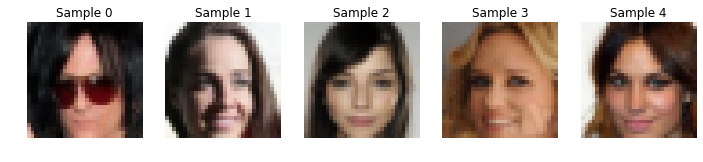

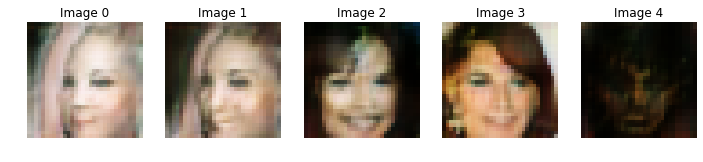

Epoch: 1 / Batch: 0.632% / G Loss: 0.32048 / D Loss: 0.51710


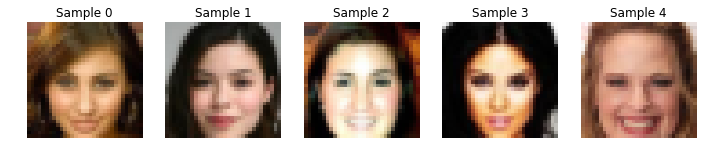

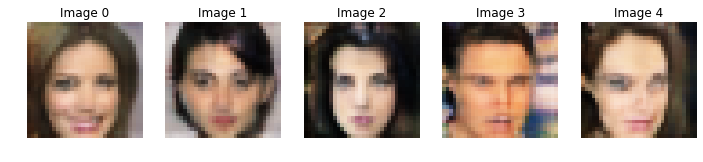

Epoch: 1 / Batch: 0.948% / G Loss: 0.46424 / D Loss: 0.42330


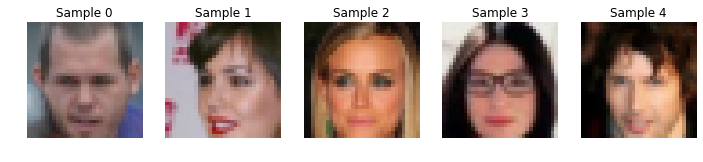

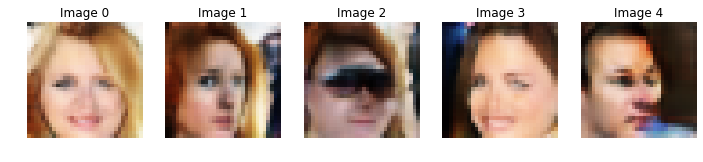

Epoch: 2 / Batch: 0.263% / G Loss: 0.38955 / D Loss: 0.41797


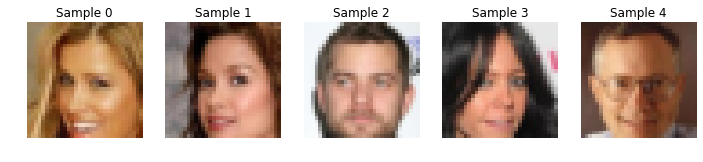

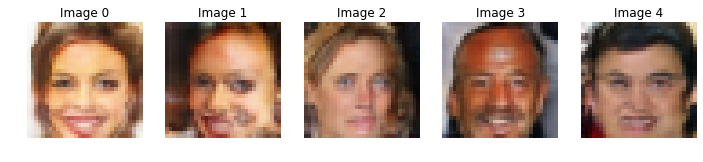

Epoch: 2 / Batch: 0.579% / G Loss: 0.45332 / D Loss: 0.39906


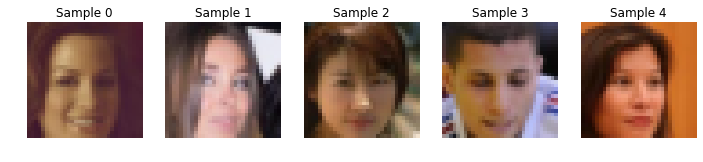

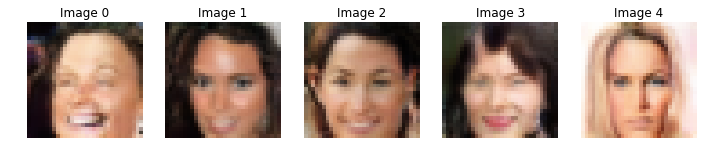

Epoch: 2 / Batch: 0.895% / G Loss: 0.44666 / D Loss: 0.47220


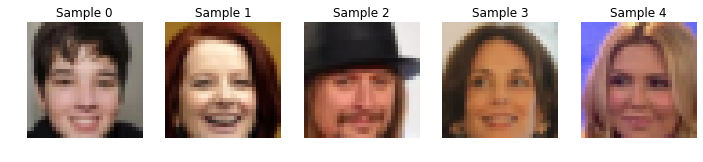

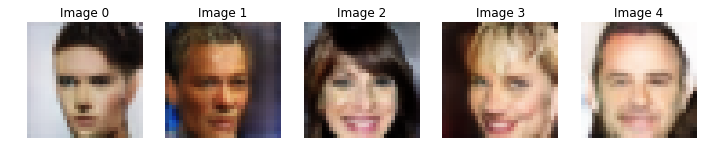

Epoch: 3 / Batch: 0.211% / G Loss: 0.43155 / D Loss: 0.44575


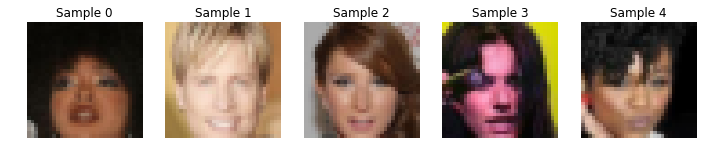

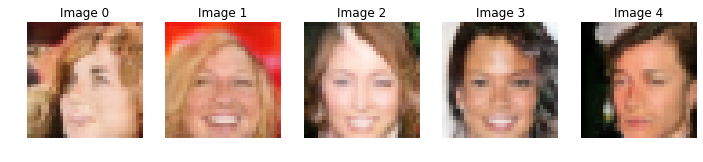

Epoch: 3 / Batch: 0.527% / G Loss: 0.63907 / D Loss: 0.37915


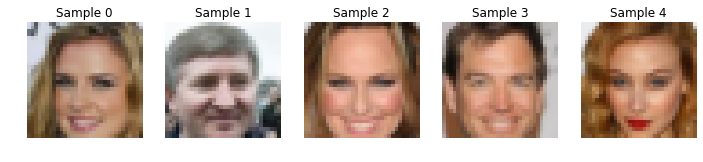

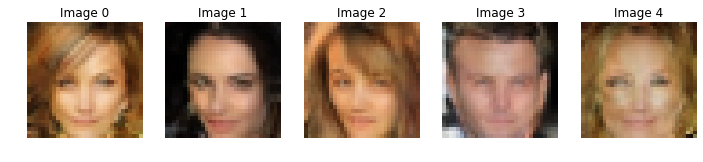

Epoch: 3 / Batch: 0.843% / G Loss: 0.73584 / D Loss: 0.46921


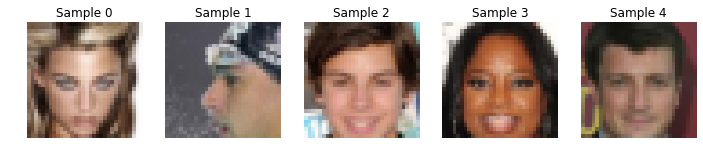

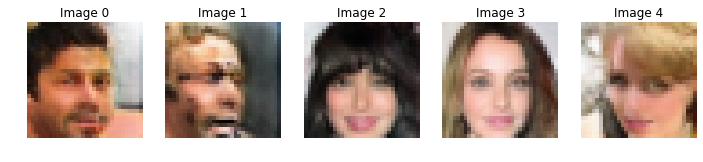

Epoch: 4 / Batch: 0.159% / G Loss: 0.58793 / D Loss: 0.33124


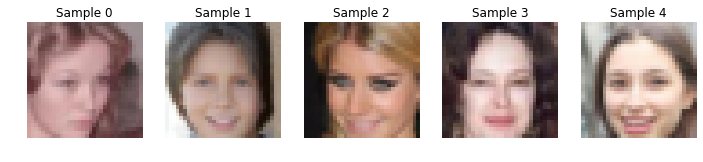

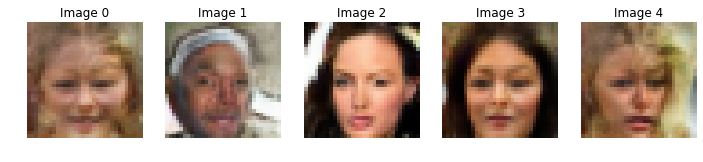

Epoch: 4 / Batch: 0.474% / G Loss: 0.92845 / D Loss: 0.42276


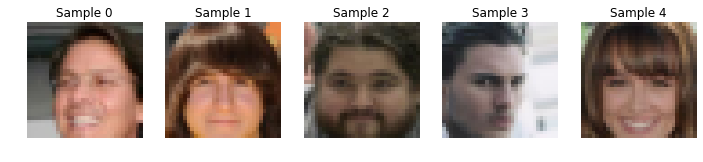

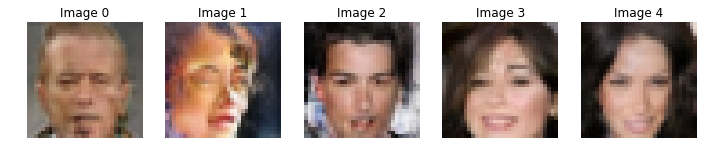

Epoch: 4 / Batch: 0.790% / G Loss: 0.58405 / D Loss: 0.38888


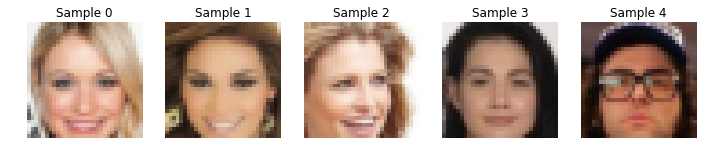

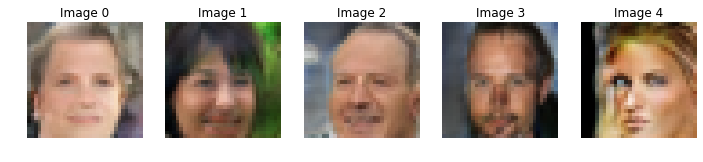

Epoch: 5 / Batch: 0.106% / G Loss: 1.04221 / D Loss: 0.41522


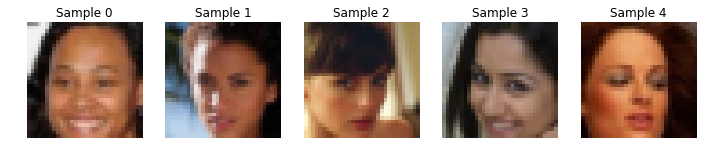

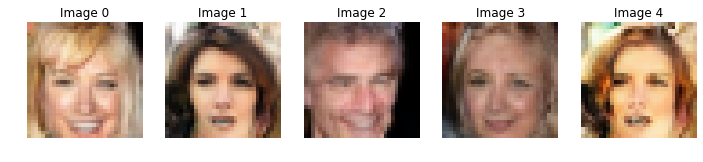

Epoch: 5 / Batch: 0.422% / G Loss: 1.24043 / D Loss: 0.39193


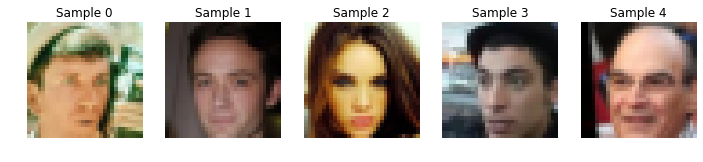

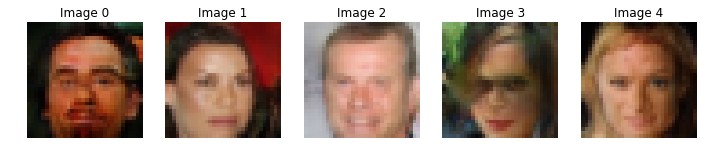

Epoch: 5 / Batch: 0.738% / G Loss: 0.59701 / D Loss: 0.33809


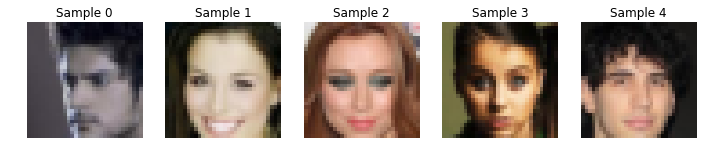

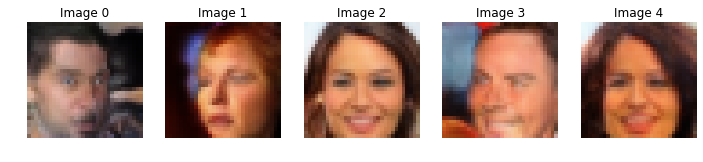

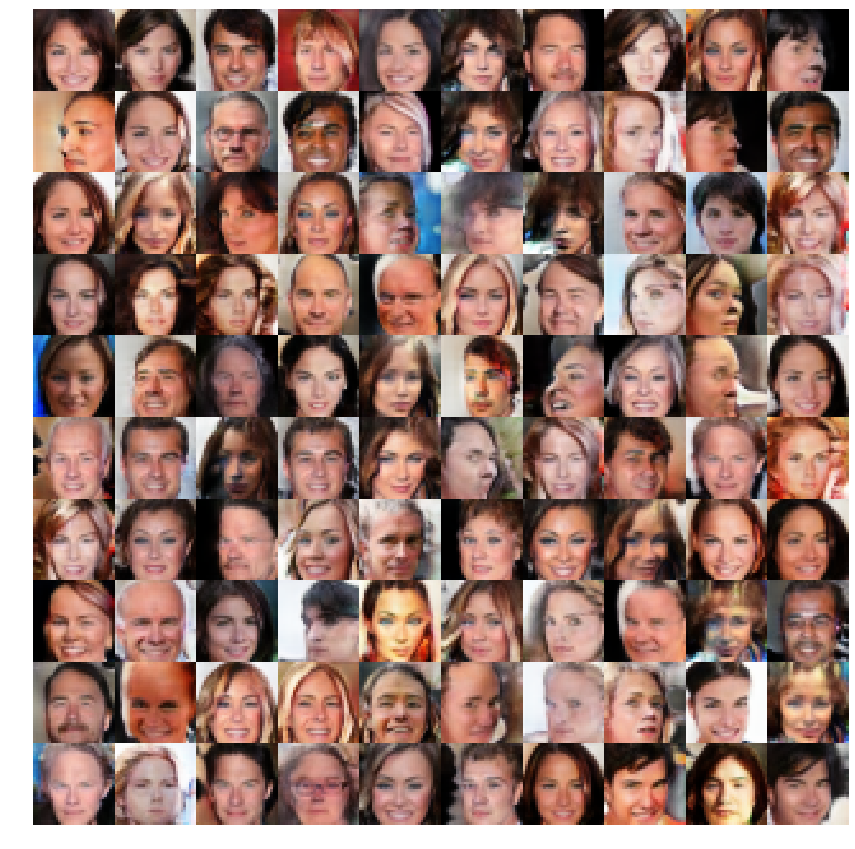


------------------ Level 3 is DONE!! ------------------

------------------- Var Assign is Finished! -------------------
Epoch: 1 / Batch: 0.158% / G Loss: 0.84988 / D Loss: 0.20075


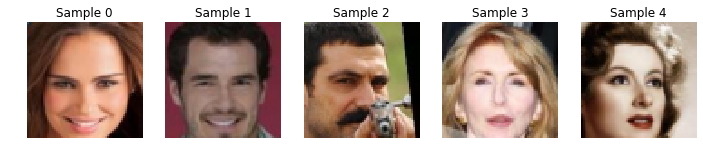

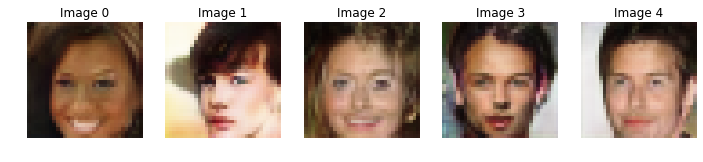

Epoch: 1 / Batch: 0.316% / G Loss: 1.20726 / D Loss: 0.10840


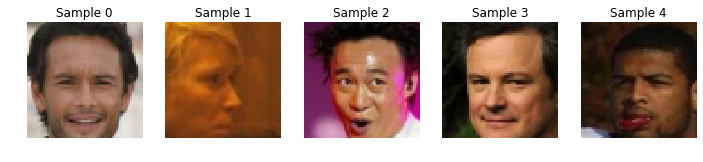

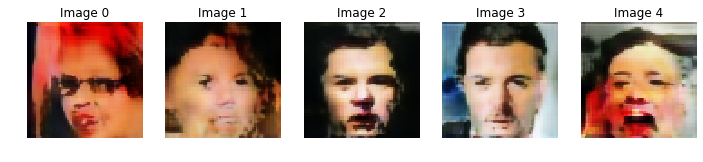

Epoch: 1 / Batch: 0.474% / G Loss: 0.97667 / D Loss: 0.00979


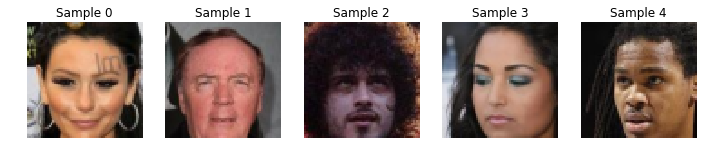

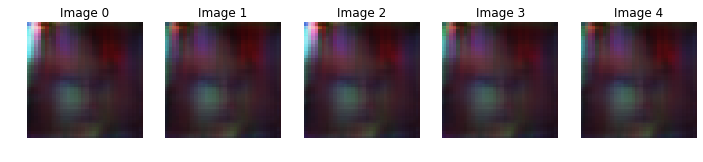

Epoch: 1 / Batch: 0.632% / G Loss: 1.02588 / D Loss: 0.00078


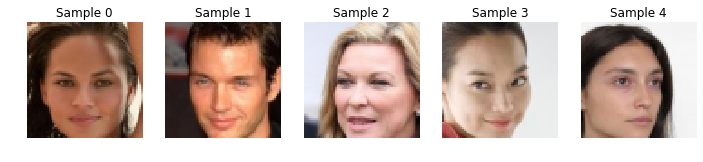

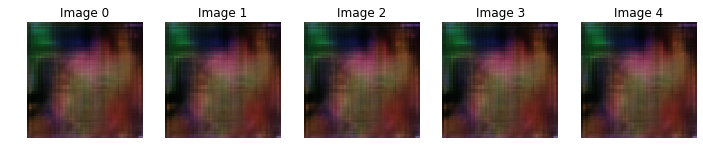

Epoch: 1 / Batch: 0.790% / G Loss: 0.99514 / D Loss: 0.00548


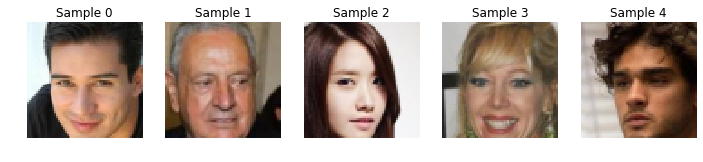

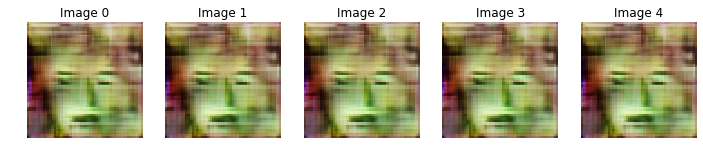

Epoch: 1 / Batch: 0.948% / G Loss: 1.03000 / D Loss: 0.00164


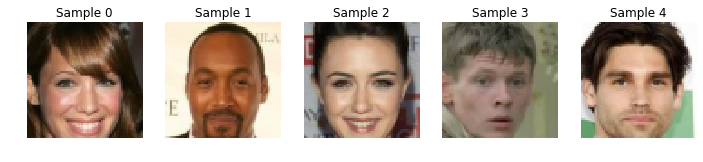

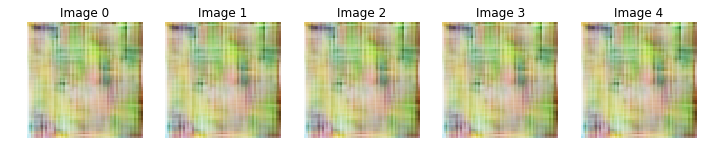

Epoch: 2 / Batch: 0.106% / G Loss: 0.99320 / D Loss: 0.00060


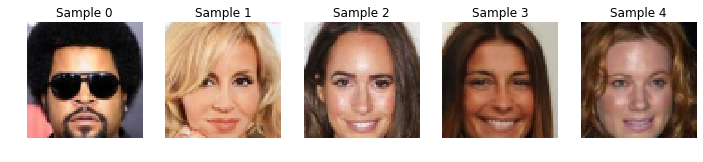

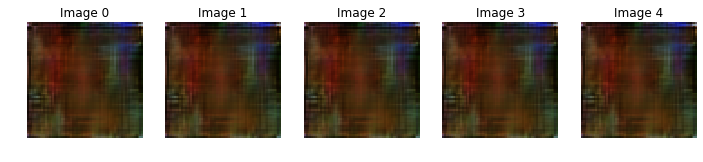

Epoch: 2 / Batch: 0.263% / G Loss: 0.88355 / D Loss: 0.00363


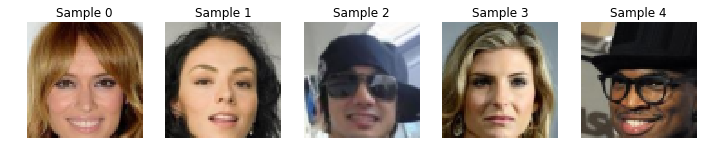

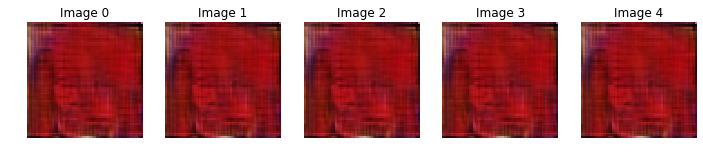

Epoch: 2 / Batch: 0.421% / G Loss: 0.99618 / D Loss: 0.00049


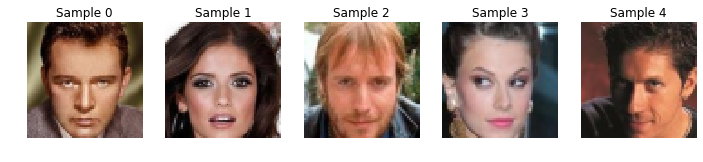

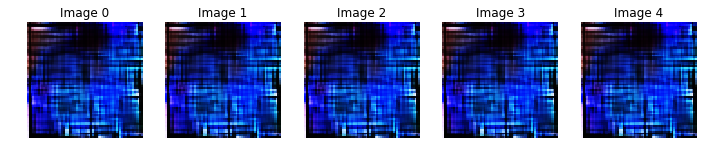

Epoch: 2 / Batch: 0.579% / G Loss: 1.00530 / D Loss: 0.00010


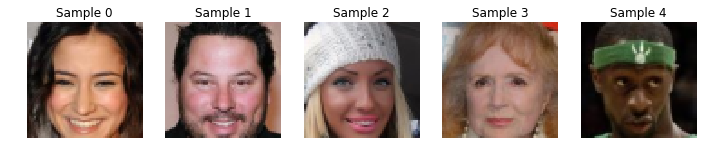

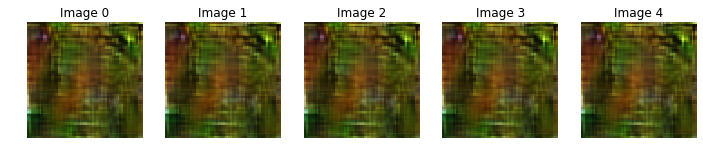

Epoch: 2 / Batch: 0.737% / G Loss: 0.99663 / D Loss: 0.00019


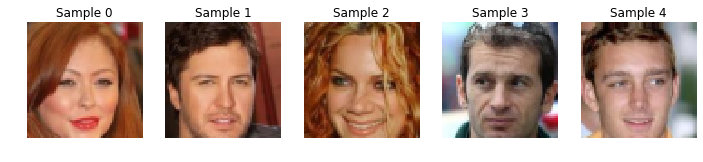

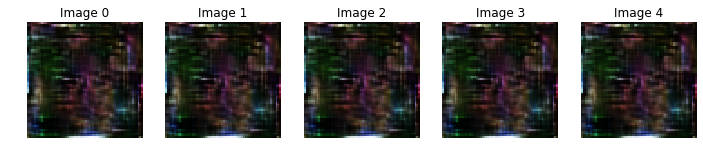

Epoch: 2 / Batch: 0.895% / G Loss: 1.00054 / D Loss: 0.00015


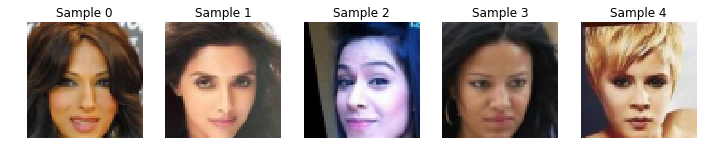

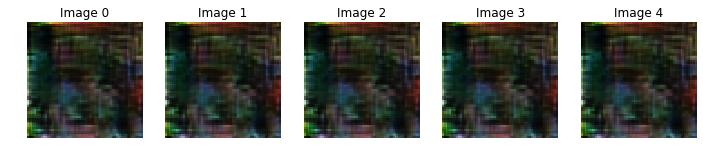

Epoch: 3 / Batch: 0.053% / G Loss: 0.94300 / D Loss: 0.00190


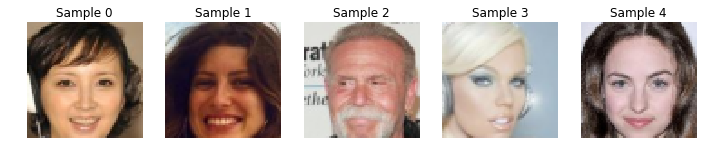

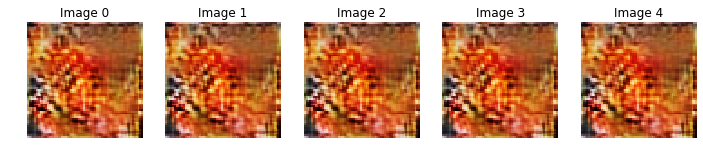

Epoch: 3 / Batch: 0.211% / G Loss: 0.99803 / D Loss: 0.00221


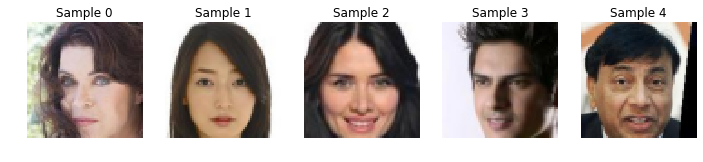

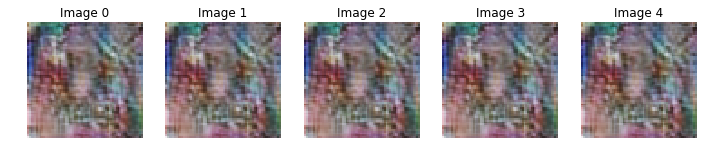

Epoch: 3 / Batch: 0.369% / G Loss: 0.99130 / D Loss: 0.01004


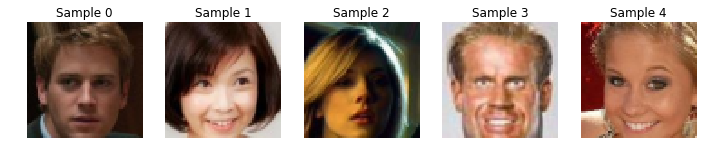

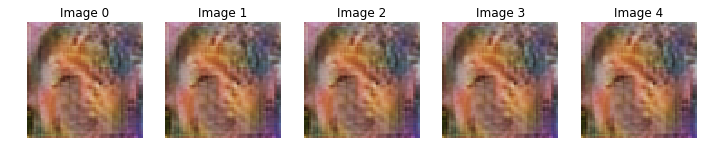

Epoch: 3 / Batch: 0.527% / G Loss: 1.02219 / D Loss: 0.00121


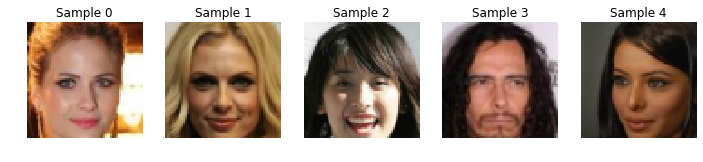

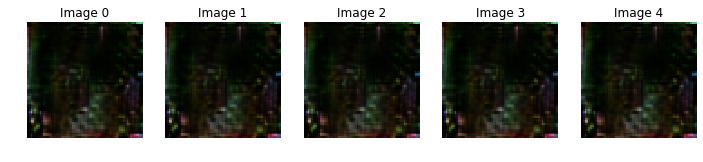

Epoch: 3 / Batch: 0.685% / G Loss: 0.99382 / D Loss: 0.00132


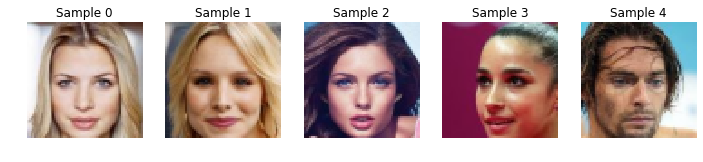

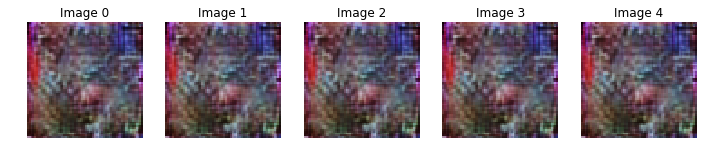

Epoch: 3 / Batch: 0.843% / G Loss: 0.99435 / D Loss: 0.00425


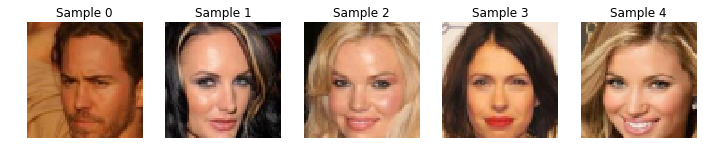

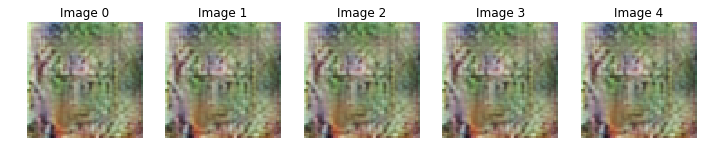

Epoch: 4 / Batch: 0.001% / G Loss: 0.99816 / D Loss: 0.00021


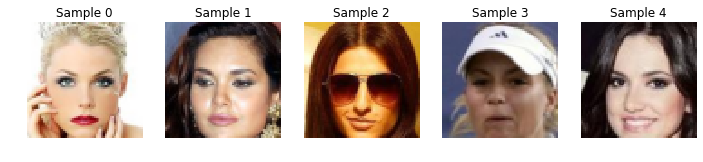

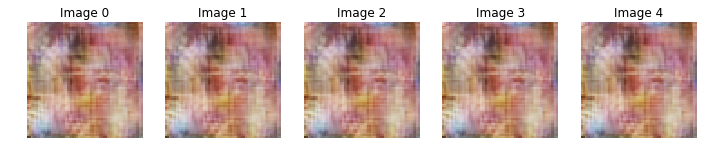

Epoch: 4 / Batch: 0.159% / G Loss: 1.02608 / D Loss: 0.00056


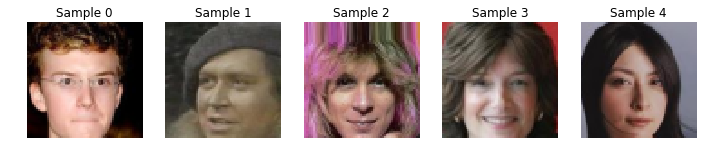

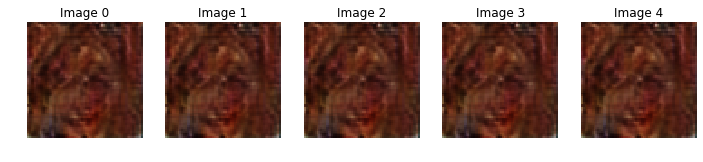

Epoch: 4 / Batch: 0.317% / G Loss: 1.34305 / D Loss: 0.40931


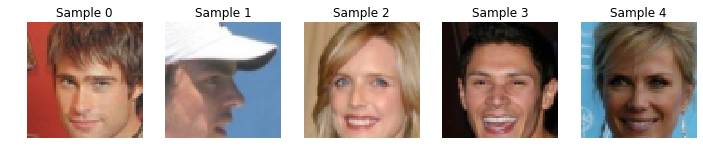

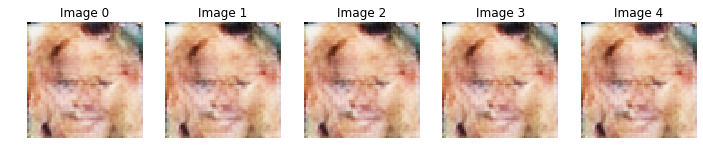

Epoch: 4 / Batch: 0.474% / G Loss: 0.97291 / D Loss: 0.00520


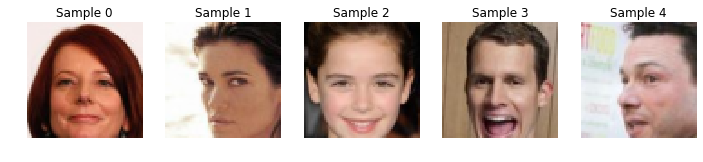

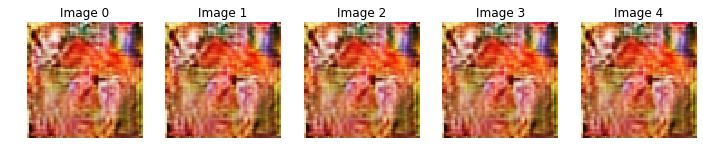

Epoch: 4 / Batch: 0.632% / G Loss: 0.96770 / D Loss: 0.17268


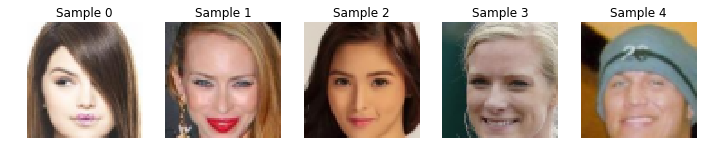

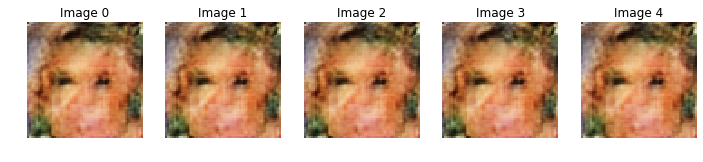

Epoch: 4 / Batch: 0.790% / G Loss: 0.93731 / D Loss: 0.00588


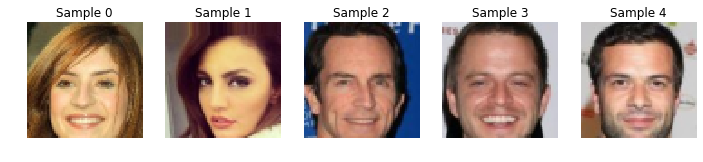

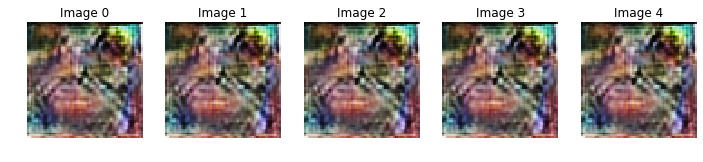

Epoch: 4 / Batch: 0.948% / G Loss: 0.98895 / D Loss: 0.00073


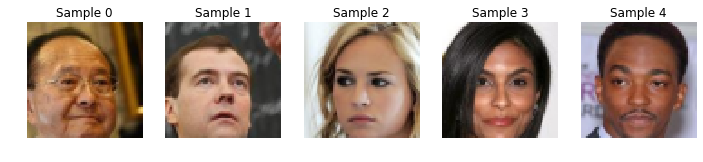

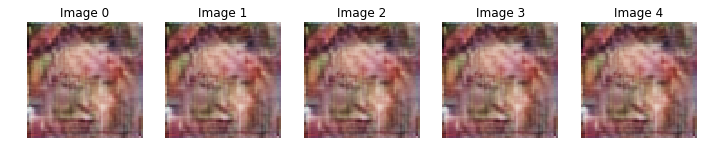

Epoch: 5 / Batch: 0.106% / G Loss: 1.00199 / D Loss: 0.00065


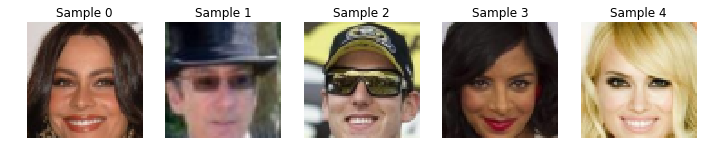

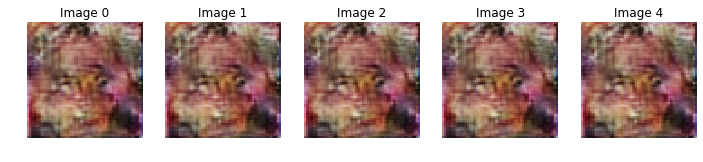

Epoch: 5 / Batch: 0.264% / G Loss: 0.99456 / D Loss: 0.00061


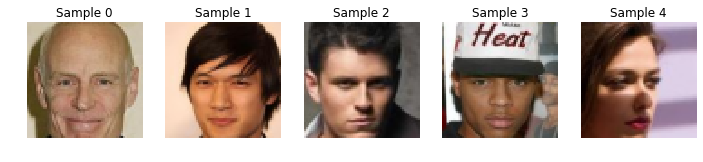

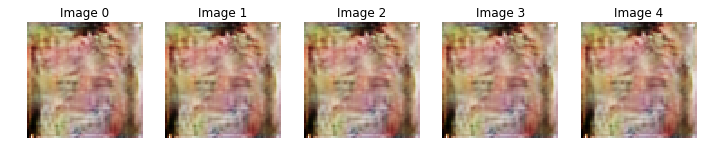

Epoch: 5 / Batch: 0.422% / G Loss: 0.99872 / D Loss: 0.00106


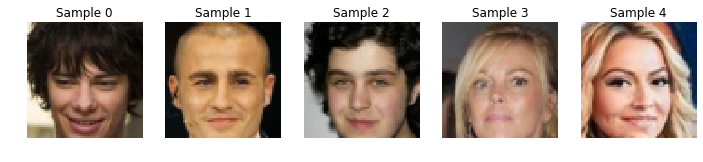

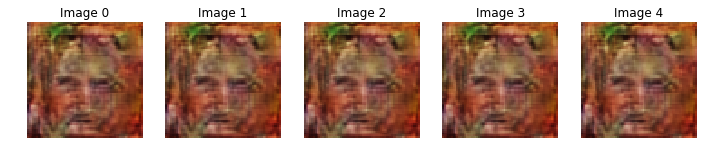

Epoch: 5 / Batch: 0.580% / G Loss: 1.06785 / D Loss: 0.00270


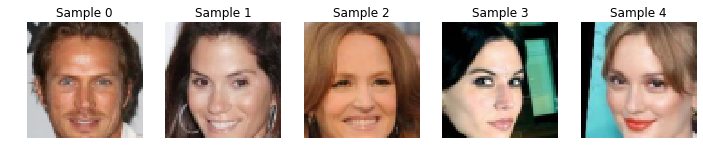

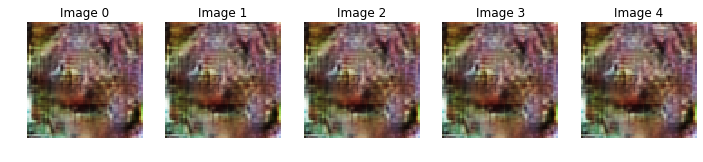

Epoch: 5 / Batch: 0.738% / G Loss: 1.02141 / D Loss: 0.00231


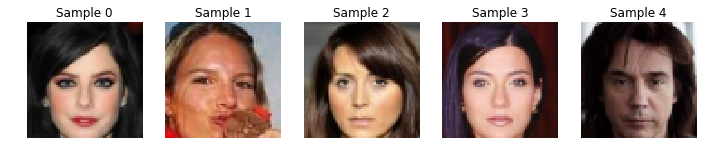

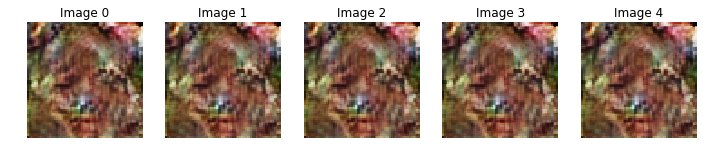

Epoch: 5 / Batch: 0.896% / G Loss: 1.00259 / D Loss: 0.00235


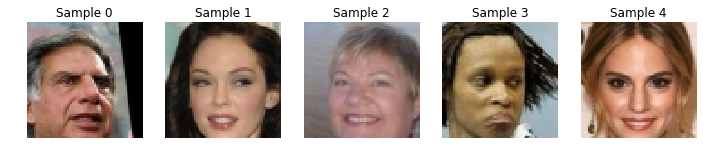

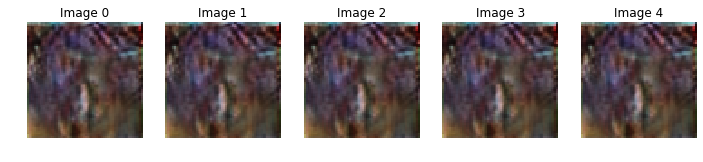

Epoch: 6 / Batch: 0.054% / G Loss: 0.98659 / D Loss: 0.00033


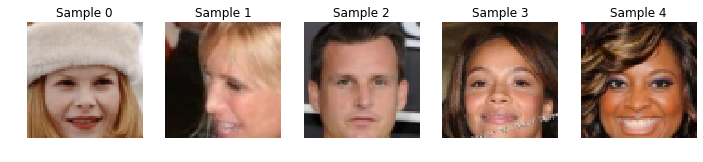

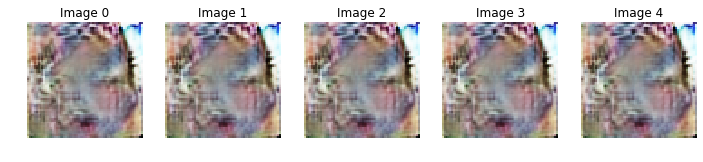

Epoch: 6 / Batch: 0.212% / G Loss: 0.99787 / D Loss: 0.00021


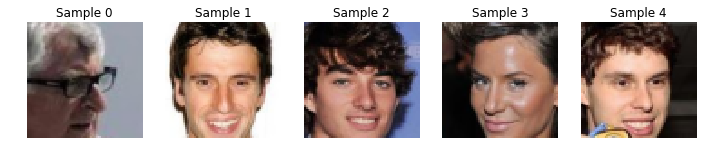

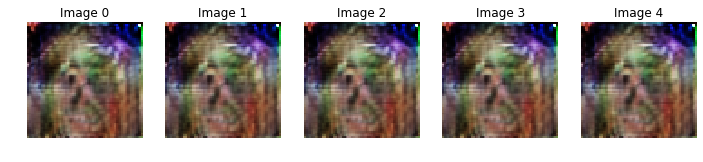

Epoch: 6 / Batch: 0.370% / G Loss: 1.02797 / D Loss: 0.00313


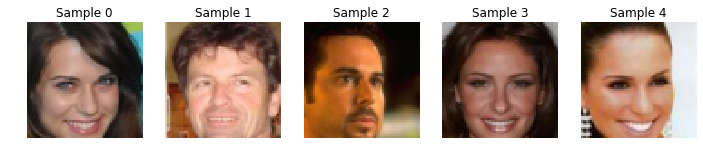

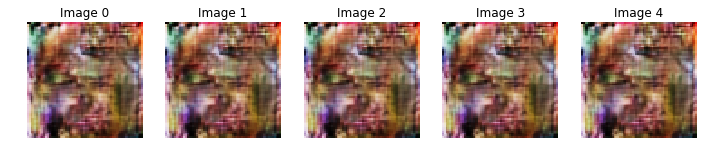

KeyboardInterrupt: 

In [9]:
if train_model:
    # Training
    len_data = len(celebA_list)

    for m in range(len(size_list)):
        # Define models and set parameters for new level
        model = model_list[m]
        alpha = 0
        count_step = 0
        
        batch_size = batch_list[m]
        epoch = epoch_list[m]
        
        # Assign the parameters to the new layers
        if m != 0:
            model_var_d = model.trainable_vars_d
            model_var_g = model.trainable_vars_g
            
            model_old_var_d = model_old.trainable_vars_d
            model_old_var_g = model_old.trainable_vars_g
            
            for var_d in model_var_d:
                var_d_split = var_d.name.split('/')
                for var_old_d in model_old_var_d:
                    var_old_d_split = var_old_d.name.split('/')
                    
                    if var_d_split[1] == var_old_d_split[1] and var_d_split[2] == var_old_d_split[2]:
                        sess.run(var_d.assign(var_old_d))

            for var_g in model_var_g:
                var_g_split = var_g.name.split('/')
                for var_old_g in model_old_var_g:
                    var_old_g_split = var_old_g.name.split('/')
                    
                    if var_g_split[1] == var_old_g_split[1] and var_g_split[2] == var_old_g_split[2]:
                        sess.run(var_g.assign(var_old_g))
            
            print('------------------- Var Assign is Finished! -------------------')
        for i in range(epoch):
            # Shuffle the data 
            np.random.shuffle(celebA_list)
            
            count_batch = 0
            
            # Making mini-batch
            for j in range(0, len_data, batch_size):
                # Get alpha for weighting the new layers 
                alpha = 1.5 * i/epoch + (1/epoch) * (j / len_data)
                
                if alpha > 1:
                    alpha = 1.0
                
                if j + batch_size < len_data:
                    x_in = np.zeros([batch_size, img_size, img_size, 3])

                    for k in range(batch_size):
                        img_temp = cv2.imread(celebA_list[j + k])
                        x_in[k,:,:,:] = img_temp[45:45 + img_size, 25: 25+img_size, :]

                x_in = x_in.reshape((-1, img_size, img_size, 3))
                
                x_in_resize = np.zeros([x_in.shape[0], size_list[m], size_list[m], 3])
                
                for k in range(x_in.shape[0]):
                    x_in_resize[k,:,:,:] = resize(x_in[k,:,:,:], (size_list[m], size_list[m]))
                
                x_in_resize = np.float32(x_in_resize / 255.0)
                
                sampled_z = np.random.uniform(-1, 1, size=(x_in_resize.shape[0] , n_latent))              
                
                # Run Optimizer!
                _, loss_d = sess.run([model.train_step_d, model.d_loss], feed_dict = {model.x: x_in_resize, 
                                                                                      model.z: sampled_z,
                                                                                      model.alpha: [alpha],
                                                                                      model.batch_size: batch_size})
                _, loss_g = sess.run([model.train_step_g, model.g_loss], feed_dict = {model.x: x_in_resize, 
                                                                                      model.z: sampled_z, 
                                                                                      model.alpha: [alpha],
                                                                                      model.batch_size: batch_size})

                print("Batch: {} / {}, Alpha: {}".format(count_batch, int(len_data/batch_size), alpha), end="\r")
                
                count_batch += 1
                
                if count_step % show_result_step == 0 and count_step != 0:
                    # Print Progess
                    print("Epoch: {} / Batch: {:.3f}% / G Loss: {:.5f} / D Loss: {:.5f}".format((i+1), (j/len_data), 
                                                                                                 loss_g, loss_d))

                    # Show test images 
                    z_test = np.random.uniform(-1, 1, size=(5, n_latent))
                    G_out = sess.run(model.G, feed_dict = {model.z:z_test, model.alpha:[alpha], model.batch_size:5})
                    
                    G_out = (G_out + 1.0)/2
                    
                    f1, ax1 = plt.subplots(1,5, figsize=(12,12))
                    for k in range(5):
                        img_RGB = cv2.cvtColor(x_in_resize[k,:,:,:], cv2.COLOR_BGR2RGB)
                        ax1[k].imshow(img_RGB)
                        ax1[k].axis('off')
                        ax1[k].set_title('Sample '+str(k))

                    f2, ax2 = plt.subplots(1,5, figsize=(12,12))
                    for k in range(5):
                        img_RGB = cv2.cvtColor(G_out[k,:,:,:], cv2.COLOR_BGR2RGB) 
                        ax2[k].imshow(img_RGB)
                        ax2[k].axis('off')
                        ax2[k].set_title('Image '+str(k))

                    plt.show()

                    count_step = 0

                count_step+=1
        
        # Test Result of Each Level
        num_test = 10

        img = np.zeros([size_list[m] * num_test, size_list[m] * num_test, 3])

        z_result = np.random.uniform(-1, 1, size=(num_test**2, n_latent))
        G_result = sess.run(model.G, feed_dict = {model.z: z_result,  
                                                  model.alpha: [1.0], model.batch_size: num_test**2})
        G_result = (G_result + 1.0)/2
        
        for i in range(num_test**2):
            row_num = int(i/num_test)
            col_num = int(i%num_test)

            img[row_num * size_list[m] : (row_num + 1) * size_list[m], 
                (col_num) * size_list[m] : (col_num + 1) * size_list[m]] = G_result[i,:,:,:]
        
        img_RGB = cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2RGB) 
        
        plt.figure(figsize=(15,15))
        plt.imshow(img_RGB)
        plt.axis('off')
        plt.show()
        
        #Save Model
        Saver.save(sess, save_path + "/" + str(size_list[m]) + "/model/model")
        print("Model is saved in {}".format(save_path + "/" + str(size_list[m]) + "/model/model"))

        model_old = model
        
        print('\n------------------ Level {} is DONE!! ------------------\n'.format(m))

## Image Generation

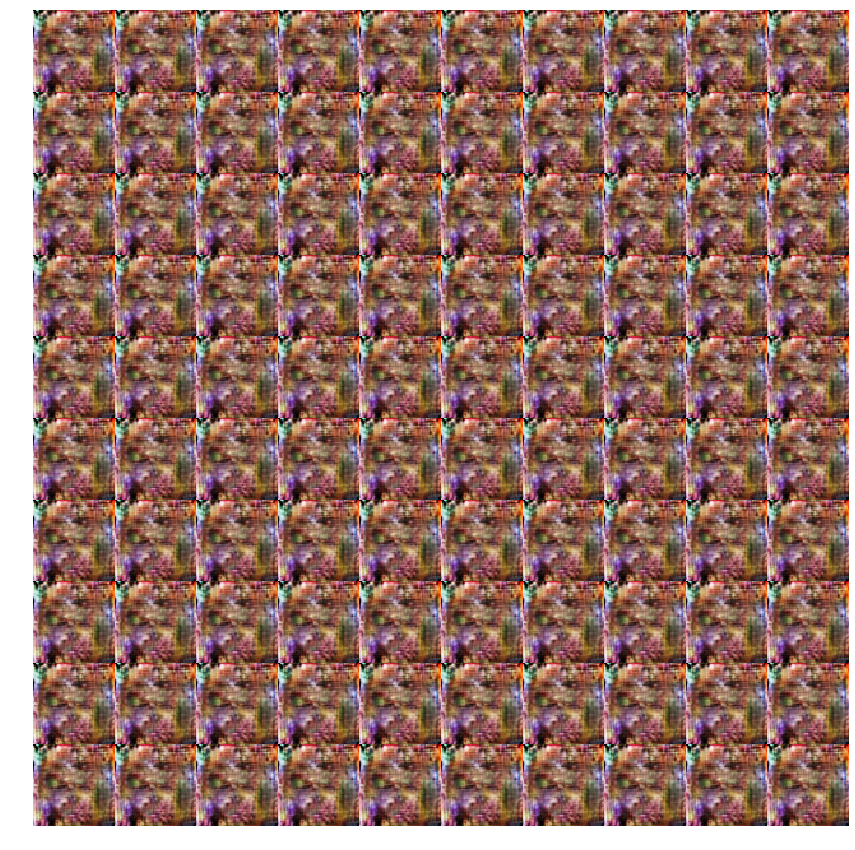

In [11]:
# Test Result of Each Level
num_test = 10

img = np.zeros([size_list[m] * num_test, size_list[m] * num_test, 3])

z_result = np.random.uniform(-1, 1, size=(num_test**2, n_latent))
G_result = sess.run(model.G, feed_dict = {model.z: z_result,  
                                          model.alpha: [1.0], model.batch_size: num_test**2})
G_result = (G_result + 1.0)/2

for i in range(num_test**2):
    row_num = int(i/num_test)
    col_num = int(i%num_test)

    img[row_num * size_list[m] : (row_num + 1) * size_list[m], 
        (col_num) * size_list[m] : (col_num + 1) * size_list[m]] = G_result[i,:,:,:]

img_RGB = cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2RGB) 

plt.figure(figsize=(15,15))
plt.imshow(img_RGB)
plt.axis('off')
plt.show()

## Save Model